In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import QasmSimulator
from qiskit_aer import StatevectorSimulator
import numpy as np 
from qiskit.providers.fake_provider import FakeQuitoV2, FakeVigoV2, FakeGuadalupeV2, FakeSherbrooke
from qiskit.visualization import plot_histogram, plot_gate_map


import sys
sys.path.append('/Users/prachisharma/Documents/GitHub/PER_HVA_PIQAE_project')
from circuit_builder import CircuitBuilder
from model_hamiltonian import circuit_optimized_parameters
from helper import *

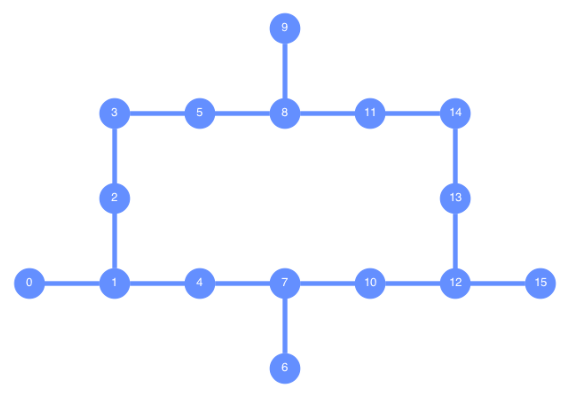

In [2]:
plot_gate_map( FakeGuadalupeV2()) 

In [3]:
# VQE ansatz: HVA layers        
num_layers = 1

### parameters for Quantum backend 
choosen_backend = FakeGuadalupeV2()
init_layout = [i for i in range(choosen_backend.num_qubits)]
# initiate the Quantum_system class
Quant_sys = Quantum_system(backend=choosen_backend, initial_layout=init_layout)
geometry = Quant_sys.backend_geometry()

# loading the optimized parameters for each backend geometry based on VQE minimization step
# One could run the VQE.py to find the optimized parameters but used parameters in the papers are saved here for reproducibility purposes. 
opt_params =  circuit_optimized_parameters(geometry)
circuits = CircuitBuilder(params = opt_params, backend =choosen_backend, initial_layout = init_layout, nlayers = num_layers)

# Circuits sent to tomography are a list
circuits_w_no_meas = [circuits.makevqeCircuit(measure = False)]
#circuits_w_no_meas[0].draw()

In [4]:
[i for i in range(16,32,1)]

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [5]:
qr_copy = QuantumRegister(2*choosen_backend.num_qubits,'qr_ps')
cr_copy = ClassicalRegister(2*choosen_backend.num_qubits,'cr_ps')
circ_double_copy = QuantumCircuit(qr_copy, cr_copy)
circ_double_copy.compose(circuits_w_no_meas[0],[i for i in range(16)],inplace=True)
circ_double_copy.compose(circuits_w_no_meas[0],[i for i in range(16,32,1)], inplace=True)

#circ_double_copy.measure([0,1,2,3,4],[5,6,7,8,9])
#circ_double_copy.draw()

In [6]:
def bell_basis(qc, qr0, qr1):
    qc.cx(qr0,qr1)
    qc.h(qr0)
    return qc

def bell_basis_measure(qc,qr0, qr1,cr0,cr1):
    qc.measure(qr0,cr0)
    qc.measure(qr1,cr1)
    return qc

Optimzation level 3 is essential for simulation

In [15]:
from qiskit_aer import AerSimulator
simulator = AerSimulator (method='matrix_product_state')

init_layout = [19,20,33,39,21,40,15,22,41,53,23,42,24,34,43,25] +[44,45,54,64,46,65,35,47,66,73,48,67,49,55,68,50]
transpiled  = QuantumCircuit(FakeSherbrooke().num_qubits, 2*16)
transpiled = transpile(circ_double_copy, backend=FakeSherbrooke(), optimization_level=3 , initial_layout=init_layout)

zip_iter =zip([19,20,33,39,21,40,15,22,41,53,23,42,24,34,43,25] ,[44,45,54,64,46,65,35,47,66,73,48,67,49,55,68,50])  #zip([i for i in range(16)],[i for i in range(16,32,1)])
#zip([19,20,33,39,21,40,15,22,41,53,23,42,24,34,43,25] ,[44,45,54,64,46,65,35,47,66,73,48,67,49,55,68,50]) 
cr = 0
for i,j in zip_iter:
    transpiled = bell_basis(transpiled, i,j)
    transpiled = bell_basis_measure(transpiled, i, j,cr , cr+1 )
    cr+=2
#transpiled.draw()

/opt/anaconda3/envs/Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [19]:
# Uncomment to simulate the circuit on the simulator and not on the specific backend

#from qiskit_aer import AerSimulator
#simulator = AerSimulator(method='matrix_product_state')

#transpiled  = QuantumCircuit(2*16, 2*16)
#transpiled = transpile(circ_double_copy, backend=simulator, optimization_level=3)

#zip_iter = zip([i for i in range(16)],[i for i in range(16,32,1)])

#cr = 0
#for i,j in zip_iter:
#    transpiled = bell_basis(transpiled, i,j)
#    transpiled = bell_basis_measure(transpiled, i, j,cr , cr+1 )
#    cr+=2
#transpiled.draw()

In [16]:
shots = 2**16 # 22
result = simulator.run(transpiled, shots=shots, memory=True).result()
counts = result.get_counts(transpiled)

In [17]:
memory = result.get_memory(transpiled)

In [18]:
len(memory[0])

32

------------

In [20]:
def mapped_bell_state(st =''):
    mapping_dict = {"00": '0', '01':'1',"10":'2',"11":'3'}
    map_state = mapping_dict[st]
    return map_state

print(mapped_bell_state(st ='11'))

def map_comp_basis_2_bell_basis(comp_out = ''):
    """
    00 -> 0
    01 -> 1 
    10 -> 2
    11 -> 3
    """

    mapping = ''
    for i in range(0,len(comp_out),2):
        #print(comp_out[i:i+2])
        transform = mapped_bell_state(comp_out[i:i+2])
        mapping += transform #comp_out[i:i+2]
        #print(mapping)
    return mapping 

map_comp_basis_2_bell_basis(''.join(reversed('0110000000'))),map_comp_basis_2_bell_basis('0110000000')

3


('00012', '12000')

In [21]:
dict_X_trace_mapping = {"0": 1,"1": -1,"2": 1,"3": -1 }
dict_Z_trace_mapping = {"0": 1,"1": 1,"2": -1,"3": -1 }
dict_Y_trace_mapping = {"0": -1,"1": 1,"2": 1,"3": -1 }
dict_I_trace_mapping = {"0": 1,"1": 1,"2": 1,"3": 1 }
# for t = 1 first


def map_pauli_str(st ='XXZXY', count_st = '00012'):
    trace = 1
    for i, j in zip(st,count_st):
        #print(i,j)
        if i == "X":
            trace *= dict_X_trace_mapping[j]
            #print(i, j, ans)
        elif i =='Z':
            trace *= dict_Z_trace_mapping[j]
            #print(i, j,ans)
        elif i =='Y':
            trace *= dict_Y_trace_mapping[j]
            #print(i, j,ans)
        elif i =='I':
            trace *= dict_I_trace_mapping[j]
        else: 
            print("incorrect operator") 
            
    # print("ans = ", ans)
    return trace 



def expectation_w_shots_(Nshots = 10, count_memory = memory, st ='XXZXY'):
    # print(st)
    sum = 0
    for i in range(Nshots):  
        # print(memory[i], ''.join(reversed(count_memory[i])), map_comp_basis_2_bell_basis(''.join(reversed(count_memory[i]))))      
        sum+=map_pauli_str(st, count_st= map_comp_basis_2_bell_basis(count_memory[i]) ) #''.join(reversed(map_comp_basis_2_bell_basis(count_memory[i]))))
        #print(sum)
    return sum/Nshots
    



0.006439208984375

In [22]:

data = data_loader_pickle("/Users/prachisharma/Downloads/res_dict_1000_PER_Guadalupe.pickle")


In [23]:
data

{'0': {'IXIIIIIXIIIIXIII': 0.05426501572988011,
  'IXIIIIIXXIIIIIII': 0.05489276229968502,
  'IIIIIIIXXIIIXIII': 0.054672186010567676,
  'IXIIIIIIXIIIXIII': 0.05584776689939651,
  'IXIXIIIXIIIIIIII': 0.054504542372678585,
  'IIIIIIIXIIIIXIXI': 0.05559742917346455,
  'IIIIIIIIXIIIXIXI': 0.05441605527321186,
  'IXIXIIIIXIIIIIII': 0.05294261747982681,
  'IXIXIIIIIIIIXIII': 0.06100225184440861,
  'IXIIIIIXIIIIIIXI': 0.05908417101320517,
  'IXIIIIIIIIIIXIXI': 0.05495086167684387,
  'IIIXIIIXXIIIIIII': 0.05353770031758069,
  'IIIXIIIXIIIIXIII': 0.05299091410616503,
  'IIIIIIIXXIIIIIXI': 0.05787559407061095,
  'IXIIIIIIXIIIIIXI': 0.057412470989967004,
  'IIIXIIIIXIIIXIII': 0.05359308803649318,
  'IIIIIXIXIIIIXIII': 0.0545040514850692,
  'IXIIIIIXIIIXIIII': 0.05592171842225187,
  'IXIIIXIXIIIIIIII': 0.0522616689336941,
  'IXIIIIIXIIIIIXII': 0.056636285354004494,
  'IIXIIIIXIIIIXIII': 0.05369884978140746,
  'IIIIIIIXIIIXXIII': 0.05491061984746146,
  'IXIIIXIIIIIIXIII': 0.05469215477927454,
  'I

In [28]:
[key for key in range(1)]

[0]

In [25]:
operator = 'IXIIIIIXIIIIXIII'
qiskit_operator = ''.join(reversed(operator))

In [35]:
after_drop_data = {}
drop_data = {} 
shot_noise = 1/np.sqrt(shots)
epsilon = 2*shot_noise #10**(-2)
for i in range(82):
    keys = data[str(i)]
    for key in keys:
        qiskit_operator = ''.join(reversed(key))
        exp_val = abs(expectation_w_shots_(Nshots = shots, count_memory=memory, st =qiskit_operator))
        #sv_val = SV.expectation_value(SparsePauliOp(qiskit_operator))**2
        if exp_val >= epsilon:
            after_drop_data[key] = [exp_val]
        else:
            drop_data[key] = [exp_val]


## This drop in the number of operator measurement may/may not affect the number of Pauli groups that needs to be measured 

In [31]:
len(data['0'])

696

In [39]:
ads = len(after_drop_data)

In [42]:
ds = len(drop_data)
ds/(ads+ds)

0.1597818677573279